In [1]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import io
import zipfile
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
file_id = '1Z03YaFEvmGW5dapUex99nQF_Vxa2lriJ'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('asl_1000.zip')
!unzip -q asl_1000.zip

In [2]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import pathlib

batch_size = 32
img_height = 200
img_width = 200
data_dir_tv = "asl_1000/asl_alphabet_train"
data_dir_test = "asl_1000/asl_alphabet_test"
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [3]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_tv,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_tv,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_test,
  image_size=(img_height, img_width),
  shuffle = False,
  batch_size=batch_size)

test_ds = test_ds.map(lambda x, y: (x, tf.constant([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25])))

norm_train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
norm_val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))
norm_test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))


Found 26000 files belonging to 26 classes.
Using 20800 files for training.
Found 26000 files belonging to 26 classes.
Using 5200 files for validation.
Found 26 files belonging to 1 classes.


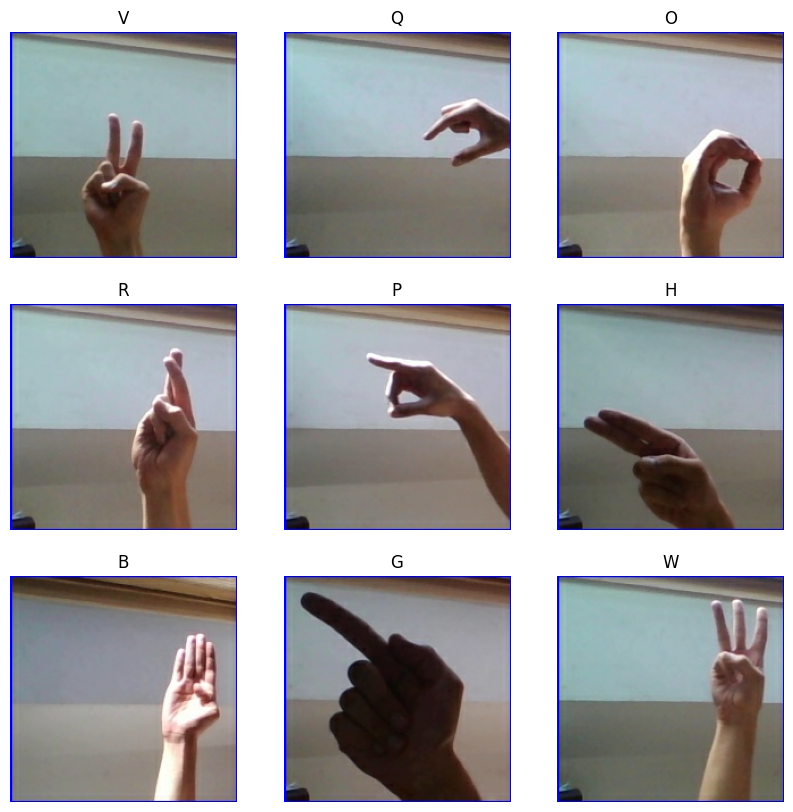

In [4]:
import matplotlib.pyplot as plt

class_names = train_ds.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [5]:
model_cnn = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(filters=25, kernel_size=(10, 10), activation='relu', input_shape=(200, 200, 3)),
  tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
  tf.keras.layers.Conv2D(filters=50, kernel_size=(10, 10), activation='relu'),
  tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(26, activation='softmax')
])

model_cnn.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 191, 191, 25)        │           7,525 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 95, 95, 25)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 86, 86, 50)          │         125,050 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 43, 43, 50)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 92450)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      11,833,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 26)                  │           3,354 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,986,169 (45.72 MB)

 Trainable params: 11,986,169 (45.72 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/4
650/650 ━━━━━━━━━━━━━━━━━━━━ 6216s 10s/step - accuracy: 0.4035 - loss: 2.0771 - val_accuracy: 0.9002 - val_loss: 0.3267
Epoch 2/4
650/650 ━━━━━━━━━━━━━━━━━━━━ 6045s 9s/step - accuracy: 0.9118 - loss: 0.2707 - val_accuracy: 0.9417 - val_loss: 0.1760
Epoch 3/4
650/650 ━━━━━━━━━━━━━━━━━━━━ 5912s 9s/step - accuracy: 0.9650 - loss: 0.1055 - val_accuracy: 0.9538 - val_loss: 0.1565
Epoch 4/4
650/650 ━━━━━━━━━━━━━━━━━━━━ 6190s 9s/step - accuracy: 0.9676 - loss: 0.1134 - val_accuracy: 0.9785 - val_loss: 0.0836


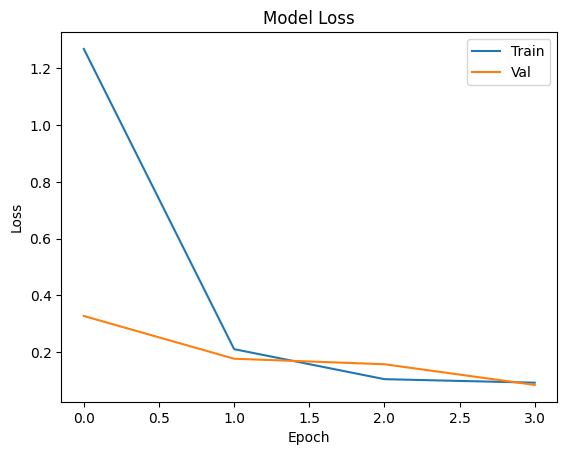

In [7]:
model_cnn.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
hist =  model_cnn.fit(norm_train_ds, validation_data = norm_val_ds, epochs = 4)

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'])
plt.show()

In [8]:
score, acc = model_cnn.evaluate(norm_test_ds)
print("Test accuracy:", acc)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9615 - loss: 0.9283
Test accuracy: 0.9615384340286255
